# 2.1 Document Clustering with Key Words Extraction (TF-IDF Weightage)

## 2.1.1 Data Import

#### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import copy

import nltk
import gensim
import k_means
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

## 2.1.2 Train and Test Data Pre-Processing

#### Preparing Training Corpus and Pre-Processing Training Data

In [4]:
train_corpus = nltk.corpus.PlaintextCorpusReader("./TrainTest_Transcripts/Train", ".+\.txt")
train_fids = train_corpus.fileids()

In [5]:
# Preparing List of Stop Words and Stemming using NLTK Library 
stop_list = nltk.corpus.stopwords.words("english")
newStopWords = ['ok','okay']
stop_list.append(newStopWords)


stemmer = nltk.stem.porter.PorterStemmer()

trainData_tokenized = [train_corpus.words(fid) for fid in train_fids] 
trainData_lowerCase = [[w.lower() for w in doc] for doc in trainData_tokenized]
trainData_removedPunct = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in trainData_lowerCase]
trainData_removedStopwords = [[w for w in doc if w not in stop_list] for doc in trainData_removedPunct]
trainData_processed = [[stemmer.stem(w) for w in doc] for doc in trainData_removedStopwords]

#### Preparing Test Corpus and Pre-Processing Test Data

In [8]:
test_corpus = nltk.corpus.PlaintextCorpusReader("./TrainTest_Transcripts/Test", ".+\.txt")
test_fids = test_corpus.fileids()

In [ ]:
# Preparing List of Stop Words and Stemming using NLTK Library 
testData_tokenized = [test_corpus.words(fid) for fid in test_fids] 
testData_lowerCase = [[w.lower() for w in doc] for doc in testData_tokenized]
testData_removedPunct = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in testData_lowerCase]
testData_removedStopwords = [[w for w in doc if w not in stop_list] for doc in testData_removedPunct]
testData_processed = [[stemmer.stem(w) for w in doc] for doc in testData_removedStopwords]

#### Converting Train Data into Sparse Vector with TF-IDF Weightage 

In [6]:
# Word dictionary 
dict_train = gensim.corpora.Dictionary(trainData_processed)

# Bag of Words Vector 
bowVec_train = [dict_train.doc2bow(doc) for doc in trainData_processed] 

# TF*IDF Model for Training Data 
tfidfModel_train = gensim.models.TfidfModel(bowVec_train) 

# Sparse Vector with TFIDF Weightage
SparseVec_train = [tfidfModel_train[vec] for vec in bowVec_train] 

In [7]:
print(len(dict_train))
new_nparray = gensim.matutils.corpus2dense(SparseVec_train, len(dict_train))

32084


## 2.1.3 Data Clustering

### 2.1.3.1 Identifying Optimal K 
Adapted from: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [ ]:
Sum_of_squared_distances = [] 
K = range(1,101)
for k in K:
    print("running: ", k)
    km = KMeans(n_clusters=k)
    km = km.fit(new_nparray)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
# Plotting overall view where K ranges from 1 to 100 
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Zooming into the region of interest

In [17]:
# Sum_of_squared_distances 40 - 50 
Sum_of_squared_distances_40_50 = [] 
K = range(40,51)
for k in K:
    print("running: ", k)
    km = KMeans(n_clusters=k)
    km = km.fit(new_nparray)
    Sum_of_squared_distances_40_50.append(km.inertia_)

running:  40
running:  41
running:  42
running:  43
running:  44
running:  45
running:  46
running:  47
running:  48
running:  49
running:  50


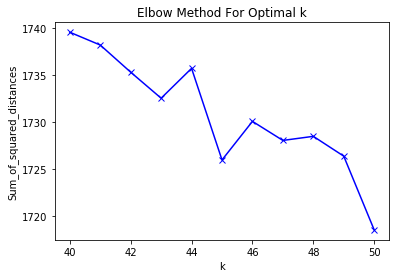

In [18]:
K = range(40,51)
plt.plot(K, Sum_of_squared_distances_40_50, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
# Sum_of_squared_distances 70 - 81 
Sum_of_squared_distances_70_81 = [] 
K = range(70,81)
for k in K:
    print("running: ", k)
    km = KMeans(n_clusters=k)
    km = km.fit(new_nparray)
    Sum_of_squared_distances_70_81.append(km.inertia_)

running:  70
running:  71
running:  72
running:  73
running:  74
running:  75
running:  76
running:  77
running:  78
running:  79
running:  80


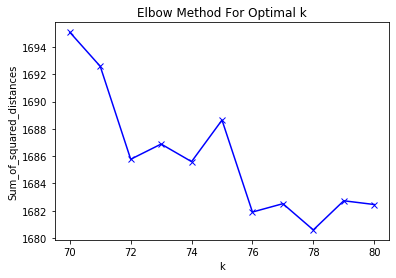

In [20]:
K = range(70,81)
plt.plot(K, Sum_of_squared_distances_70_81, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 2.1.3.2 Clustering Corpus based on Optimal-K of 75


#### Fine Tuning Train Data - Extracting Top-N Weighted Words from each Document 

In [8]:
# Function to extract top-N words from Document
def Extract_Doc_Top_N_Tfidf_Words(orginal_list, TopNWords):
    # Sort each document word's TF-IDF weightage (list of tuples) in descending order 
    updated_list = copy.deepcopy(orginal_list)
    for index in range(0,len(updated_list)):
        updated_list[index].sort(key = lambda x: x[1], reverse=True)
        updated_list[index] = updated_list[index][:TopNWords] # Extract the top 100 weighted words  
    return updated_list  

# Function to create new Dictionary based on the new Sparse Vector
def Create_New_Dictionary(sparseVec, original_dict):
    # Converting Bag of Words ID in sparseVec into a list of Tokens 
    # E.g. list of "list of string" e.g. [['SMU','SU'],['Graduate','Wow']]
    tokenized_list = [[original_dict.get(tup[0]) for tup in doc] for doc in sparseVec] 
    return gensim.corpora.Dictionary(tokenized_list)

# Function to create new Sparse Vector based on the new dictionary 
def Create_New_Sparse_Vector(sparseVec, new_dictionary, old_dictionary):    
    # Inverting Dictionary Key and Value for new_dictionary for easier retrieval
    # From [{word_id : word}] to [{word : word_id}]
    inverted_dict = dict(zip(new_dictionary.values(), new_dictionary.keys()))
    new_sparseVec = []
    for doc in sparseVec:
        new_doc = []
        for tup in doc:
            word = old_dictionary.get(tup[0]) # retrieve word from old_dictionary          
            new_doc.append((inverted_dict.get(word),tup[1]))
        new_sparseVec.append(new_doc)
    return new_sparseVec

In [9]:
# Sparse Vector with top-N TF-IDF words from each document. 
# Keep in mind that this contains Word ID of the previous Dictionary  
extracted_SparseVec_train = Extract_Doc_Top_N_Tfidf_Words(SparseVec_train, 30) 

# Creating new set of Dictionary  
new_dict_train = Create_New_Dictionary(extracted_SparseVec_train, dict_train)

# Updating Sparse Vector's word ID 
new_SparseVec_train = Create_New_Sparse_Vector(extracted_SparseVec_train, new_dict_train, dict_train)

# Transforming Sparse Vector into np array to find optimal K 
train_nparray = gensim.matutils.corpus2dense(new_SparseVec_train, len(new_dict_train))

In [10]:
# Printing Number of Features
print(len(new_dict_train))

18055


#### Creating a cluster model

In [11]:
num_tokens = len(new_dict_train.token2id)
clusters_train = k_means.k_means(new_SparseVec_train, num_tokens, 75)

In [13]:
def covert_to_word_vector(vector, dictionary):    
    new_word_doc = []
    for tup in vector:
        word = dictionary.get(tup[0]) # retrieve word from old_dictionary          
        new_word_doc.append((word,tup[1]))
    return new_word_doc  

In [14]:
from collections import Counter

cluster_index = 0
for cluster in clusters_train:
    # Cluster contains a list of index of new_SparseVec_train
    
    cluster_tfidf = []
    cluster_words = [] 
    for sparseVec_index in cluster:
        word_vec = covert_to_word_vector(new_SparseVec_train[sparseVec_index], new_dict_train)
        for tup in word_vec: 
            if tup not in cluster_tfidf:
                cluster_tfidf.append(tup)
            cluster_words.append(tup[0])

    cluster_tfidf.sort(key = lambda x: x[1], reverse=True)
    
    cluster_words = [[word,cluster_words.count(word)] for word in set(cluster_words)]
    cluster_words.sort(key = lambda x: x[1], reverse=True)
    
    print("Cluster ", cluster_index," :")
    #print("Top TF-IDF Weighted Words :", cluster_tfidf[:30], '\n')
    print("Top Frequency :", cluster_words[:30], '\n')
    cluster_index += 1 


Cluster  1  :
Top Frequency : [['viru', 10], ['vaccin', 10], ['flu', 8], ['diseas', 7], ['immun', 6], ['outbreak', 6], ['pandem', 6], ['mosquito', 5], ['drug', 5], ['malaria', 5], ['spread', 5], ['virus', 5], ['bird', 5], ['infect', 5], ['epidem', 5], ['genet', 4], ['tamiflu', 3], ['hiv', 3], ['treatment', 3], ['transmiss', 3], ['health', 3], ['cell', 3], ['speci', 3], ['ebola', 3], ['pathogen', 3], ['data', 3], ['blood', 3], ['dose', 3], ['polio', 3], ['malari', 3]] 

Cluster  2  :
Top Frequency : [['climat', 18], ['carbon', 13], ['invest', 8], ['emiss', 8], ['energi', 7], ['greenhous', 6], ['nigeria', 6], ['countri', 6], ['crisi', 5], ['africa', 5], ['heat', 5], ['atmospher', 5], ['fossil', 5], ['ice', 5], ['republican', 4], ['ecosystem', 4], ['forest', 4], ['economi', 4], ['sustain', 4], ['capit', 4], ['renew', 4], ['african', 4], ['temperatur', 3], ['fuel', 3], ['warmer', 3], ['al', 3], ['aid', 3], ['heart', 3], ['resourc', 3], ['coal', 3]] 

Cluster  3  :
Top Frequency : [['univer

Cluster  24  :
Top Frequency : [['cell', 50], ['tissu', 15], ['cancer', 14], ['stem', 13], ['diseas', 13], ['patient', 11], ['drug', 10], ['bodi', 10], ['molecul', 10], ['tumor', 9], ['protein', 8], ['blood', 8], ['brain', 8], ['vessel', 7], ['anim', 7], ['genom', 7], ['lab', 7], ['treatment', 6], ['liver', 6], ['mous', 6], ['gene', 6], ['test', 6], ['neuron', 6], ['biolog', 6], ['pluripot', 5], ['grow', 5], ['dna', 5], ['trial', 5], ['therapi', 5], ['medicin', 5]] 

Cluster  25  :
Top Frequency : [['diseas', 9], ['dad', 6], ['symptom', 5], ['origami', 5], ['love', 4], ['alzheim', 4], ['drug', 3], ['sheet', 3], ['wife', 3], ['prevent', 3], ['doctor', 3], ['patient', 3], ['cancer', 3], ['walk', 3], ['diagnos', 3], ['women', 2], ['test', 2], ['balanc', 2], ['monster', 2], ['clinic', 2], ['parkinson', 2], ['neurologist', 2], ['motiv', 2], ['dementia', 2], ['medic', 2], ['caregiv', 2], ['exercis', 2], ['trial', 2], ['brain', 2], ['motor', 2]] 

Cluster  26  :
Top Frequency : [['car', 24], 

Cluster  48  :
Top Frequency : [['speci', 9], ['homo', 4], ['africa', 4], ['object', 4], ['axe', 3], ['exchang', 3], ['trade', 3], ['fossil', 3], ['loui', 3], ['languag', 3], ['stone', 3], ['erectu', 3], ['wage', 2], ['crisi', 2], ['predict', 2], ['network', 2], ['transact', 2], ['ethiopia', 2], ['yolo', 2], ['algorithm', 2], ['encyclopedia', 2], ['econom', 2], ['lake', 2], ['upright', 2], ['water', 2], ['spear', 2], ['earth', 2], ['contin', 2], ['adam', 2], ['bone', 2]] 

Cluster  49  :
Top Frequency : [['depress', 3], ['fear', 3], ['compani', 3], ['procrastin', 3], ['doubt', 2], ['script', 2], ['deadlin', 2], ['treatment', 2], ['electroshock', 2], ['leisur', 2], ['faith', 2], ['therapi', 2], ['creativ', 2], ['sad', 2], ['pincho', 1], ['playground', 1], ['panic', 1], ['decis', 1], ['corner', 1], ['afraid', 1], ['bed', 1], ['owner', 1], ['truth', 1], ['browser', 1], ['onstag', 1], ['fuck', 1], ['everyon', 1], ['text', 1], ['undeciph', 1], ['america', 1]] 

Cluster  50  :
Top Frequency 

Cluster  69  :
Top Frequency : [['women', 43], ['men', 21], ['woman', 13], ['girl', 9], ['rape', 7], ['sex', 7], ['gender', 6], ['femal', 6], ['sexual', 6], ['violenc', 5], ['equal', 5], ['media', 4], ['pm', 4], ['daughter', 4], ['heart', 4], ['children', 4], ['report', 4], ['mutil', 4], ['male', 4], ['femin', 4], ['countri', 4], ['invest', 3], ['trend', 3], ['acumen', 3], ['vagina', 3], ['campaign', 3], ['feminist', 3], ['son', 3], ['agn', 3], ['afghanistan', 3]] 

Cluster  70  :
Top Frequency : [['oil', 9], ['penguin', 8], ['energi', 5], ['whale', 4], ['carbon', 4], ['barrel', 3], ['fuel', 3], ['coal', 3], ['spill', 3], ['fish', 3], ['larva', 2], ['nuclear', 2], ['plume', 2], ['mexico', 2], ['nest', 2], ['ga', 2], ['cost', 2], ['gulf', 2], ['stuff', 2], ['effici', 2], ['save', 2], ['clean', 2], ['water', 2], ['marin', 2], ['petroleum', 2], ['vehicl', 2], ['auto', 2], ['bird', 2], ['hydrocarbon', 2], ['park', 2]] 

Cluster  71  :
Top Frequency : [['indian', 6], ['pakistan', 5], ['mark

# 2.1.4 Document Classification 

## 2.1.4.1 Classifying Train Data

### Creating a Labelled Dictionary for Naive Bayes Classifier 

In [71]:
all_labeled_data = []

cluster_index = 0
for cluster in clusters_train:
    cluster_dict = {}
    for sparseVec_index in cluster:
        for tup in new_SparseVec_train[sparseVec_index]: 
            if tup[0] not in cluster_dict.keys():
                cluster_dict[tup[0]] = 1 
    
    cluster_name = 'Topic ' + str(cluster_index)
    all_labeled_data.append((cluster_dict, cluster_name))
    
    cluster_index += 1

### Creating Naive Bayes Classifier 

In [72]:
classifier = nltk.NaiveBayesClassifier.train(all_labeled_data)

In [ ]:
text_dict = {}

for tup in new_SparseVec_train[3]:  
    if tup[0] not in text_dict.keys():
        text_dict[tup[0]] = 1


In [197]:
print(classifier.classify(text_dict))

Topic 0


In [239]:
# Transcript to BOW
def get_result(transcript):
    print(transcript.split())
    #dict_train.doc2bow(doc)

get_result("he hereh. eh h heh e heh ")

['he', 'hereh.', 'eh', 'h', 'heh', 'e', 'heh']


## 2.1.4.2 Classifying Test Data

#### Preparing Training Corpus and Pre-Processing Training Data

In [73]:
bowVec_test = [new_dict_train.doc2bow(doc) for doc in testData_processed]
tfidfModel_test = gensim.models.TfidfModel(bowVec_test) 
SparseVec_test = [tfidfModel_test[vec] for vec in bowVec_test] 

In [75]:
new_SparseVec_test = Extract_Doc_Top_N_Tfidf_Words(SparseVec_test, 50) 

# Convert documents into dict representation.
testData_as_dict = [{id:1 for (id, tf_value) in vec} for vec in SparseVec_test]

In [76]:
#For each document, classify and print the label.
for i in range(len(test_fids)):
    print(test_fids[i], '-->', classifier.classify(testData_as_dict[i]))

transcript_0.txt --> Topic 5
transcript_10.txt --> Topic 8
transcript_1000.txt --> Topic 16
transcript_1002.txt --> Topic 7
transcript_1008.txt --> Topic 8
transcript_1012.txt --> Topic 21
transcript_1025.txt --> Topic 21
transcript_1026.txt --> Topic 8
transcript_1034.txt --> Topic 7
transcript_1039.txt --> Topic 7
transcript_1041.txt --> Topic 33
transcript_1046.txt --> Topic 8
transcript_1048.txt --> Topic 33
transcript_1050.txt --> Topic 33
transcript_1052.txt --> Topic 5
transcript_1055.txt --> Topic 8
transcript_106.txt --> Topic 7
transcript_1060.txt --> Topic 7
transcript_1062.txt --> Topic 5
transcript_1065.txt --> Topic 8
transcript_1075.txt --> Topic 8
transcript_1077.txt --> Topic 8
transcript_1092.txt --> Topic 1
transcript_110.txt --> Topic 33
transcript_1100.txt --> Topic 8
transcript_1102.txt --> Topic 7
transcript_1108.txt --> Topic 7
transcript_1114.txt --> Topic 5
transcript_1115.txt --> Topic 8
transcript_1116.txt --> Topic 5
transcript_1118.txt --> Topic 32
transcr

transcript_2194.txt --> Topic 5
transcript_2197.txt --> Topic 5
transcript_2200.txt --> Topic 5
transcript_2201.txt --> Topic 8
transcript_2202.txt --> Topic 7
transcript_2203.txt --> Topic 5
transcript_2212.txt --> Topic 8
transcript_2215.txt --> Topic 5
transcript_2216.txt --> Topic 8
transcript_2217.txt --> Topic 8
transcript_2218.txt --> Topic 21
transcript_2220.txt --> Topic 7
transcript_2223.txt --> Topic 32
transcript_2225.txt --> Topic 7
transcript_2260.txt --> Topic 8
transcript_2265.txt --> Topic 5
transcript_2266.txt --> Topic 5
transcript_2268.txt --> Topic 69
transcript_2274.txt --> Topic 3
transcript_2283.txt --> Topic 8
transcript_2284.txt --> Topic 5
transcript_2291.txt --> Topic 5
transcript_2292.txt --> Topic 7
transcript_2293.txt --> Topic 33
transcript_2295.txt --> Topic 8
transcript_2297.txt --> Topic 5
transcript_2300.txt --> Topic 7
transcript_2309.txt --> Topic 8
transcript_2310.txt --> Topic 5
transcript_2323.txt --> Topic 8
transcript_2328.txt --> Topic 0
tran